In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [2]:
DATASET_PATH = 'dataset'
USERS_PATH = os.path.join(DATASET_PATH, 'users.csv')
MOVIES_PATH = os.path.join(DATASET_PATH, 'movies.csv')
RATINGS_PATH = os.path.join(DATASET_PATH, 'ratings_train.csv')

In [3]:
df_users = pd.read_csv(USERS_PATH)
df_users

,UserID,Gender,Age,Occupation,ZipCode
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455
...,...,...,...,...,...
6035,6035,F,25,15,32603
6036,6036,F,45,1,76006
6037,6037,F,56,1,14706
6038,6038,F,45,0,01060


In [4]:
df_movies = pd.read_csv(MOVIES_PATH)
df_movies

,MovieID,Title,Genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3947,Meet the Parents (2000),Comedy
3879,3948,Requiem for a Dream (2000),Drama
3880,3949,Tigerland (2000),Drama
3881,3950,Two Family House (2000),Drama


In [5]:
df_ratings = pd.read_csv(RATINGS_PATH)
df_ratings

,UserID,MovieID,Rating,Timestamp
0,6039,857,4,956703932
1,6039,2383,4,956703954
2,6039,592,5,956703954
3,6039,1960,4,956703977
4,6039,2018,5,956703977
...,...,...,...,...
939757,5949,1996,3,1046368734
939758,5949,1260,4,1046368750
939759,5949,3151,3,1046368831
939760,5949,3910,4,1046369026


In [6]:
M_USERS = max(len(df_users['UserID'].unique()), df_users['UserID'].max() + 1)
N_ITEMS = max(len(df_movies['MovieID'].unique()), df_movies['MovieID'].max() + 1)
print(f'# of users: {M_USERS}, # of movies: {N_ITEMS}')

# of users: 6040, # of movies: 3952


# FUNKSVD MODEL
* We have tried Bias SVD and SVD++, but fund that original FUNKSVD pweform better

In [7]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, embedding_size: int, learning_rate: float):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal()(shape=(self.n, self.k)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)


    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        print(tf.gather(self.P, indices=user_ids))
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred, user_ids, item_ids)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def val_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Validate the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        y_pred = self(user_ids, item_ids)
        loss = self.compute_loss(y_true, y_pred, user_ids, item_ids)

        return loss

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        # dot product the selected user and all item embeddings to produce predictions
        user_id = tf.cast(query[0], tf.int32)
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)
        # select the top 10 items with highest scores in y_pred
        y_top_10 = tf.math.top_k(y_pred, k=10).indices

        return y_top_10

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        user_ids = tf.cast(data[0], dtype=tf.int32)
        item_ids = tf.cast(data[1], dtype=tf.int32)
        y_true = tf.cast(data[2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:

            P = tf.gather(self.P, indices=user_ids)
            Q = tf.gather(self.Q, indices=item_ids)
            y_pred = P * Q
            loss = tf.losses.mean_squared_error(y_true, y_pred)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        pass

In [8]:
# interactions with rating >= 4 are positive interactions
POSITIVE_THRESHOLD = 4 

# each per-user validation set should contain at least 5 positive interactions
POSITIVE_PER_USER = 5

train_dataframes = []
val_dataframes = []

for i in tqdm(range(M_USERS)):
    user_all = df_ratings[df_ratings['UserID'] == i]
    user_positive = user_all[user_all['Rating'] >= POSITIVE_THRESHOLD]

    # check if there are enough positive interactions to build a validation set for this user
    if len(user_positive) >= POSITIVE_PER_USER:
        split_idx = user_positive.iloc[-POSITIVE_PER_USER].name
        user_train = user_all.loc[:split_idx]
        user_test = user_all.loc[split_idx:]
        assert user_train['Timestamp'].max() <= user_test['Timestamp'].min()
        train_dataframes.append(user_train)
        val_dataframes.append(user_test)
    else:
        train_dataframes.append(user_all)

# concat all per-user training sets
df_train = pd.concat(train_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train
df_train_norm['Rating'] -= 3
df_train_norm['Rating'] /= 2

# concat all per-user validation sets
df_val = pd.concat(val_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['Rating'] -= 3
df_val_norm['Rating'] /= 2

100%|██████████| 6040/6040 [00:11<00:00, 506.71it/s]


In [9]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)

@tf.function
def ndcg_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)

@tf.function
def recall_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)

def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the MovieID 
    data[2] is the Rating
    data[3] is the Timestamp
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] >= 4:
            y_pred = model.eval_predict_onestep(tf.gather(data, (0, 3)))
            y_true = tf.gather(data, 1)
            ndcg = ndcg_at_10(y_true, y_pred)
            recall = recall_at_10(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

        # update the model with the observerd event
        model.eval_update_onestep(data)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result

# Turning hyperparameters
* Change EMBEDDING SIZE to 512 and EPOCHS to 15

In [10]:
# hyperparameters
EMBEDDING_SIZE = 512
BATCH_SIZE = 512
N_EPOCHS = 15
LEARNING_RATE = 1e-4

In [11]:
# prepare datasets
dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = FunkSVDRecommender(m_users=M_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)

# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # validating
    for data in tqdm(dataset_val, desc='Validating'):
        loss = model.val_step(data)
        val_loss.append(loss.numpy())
    
    # record losses
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\n')

2023-01-14 13:06:19.740888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-01-14 13:06:19.740944: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-01-14 13:06:19.742564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1:


Training:   0%|          | 0/1746 [00:00<?, ?it/s]

Tensor("Identity:0", shape=(512, 512), dtype=float32)


Training: 100%|█████████▉| 1745/1746 [00:37<00:00, 38.31it/s]

Tensor("Identity:0", shape=(217, 512), dtype=float32)


Validating: 100%|██████████| 102/102 [00:00<00:00, 313.43it/s]


Tensor("Identity:0", shape=(377, 512), dtype=float32)
Epoch 1 train_loss: 0.4032, val_loss: 0.3956

Epoch 2:


Validating: 100%|██████████| 102/102 [00:00<00:00, 537.59it/s]


Epoch 2 train_loss: 0.3902, val_loss: 0.3904

Epoch 3:


Validating: 100%|██████████| 102/102 [00:00<00:00, 599.86it/s]


Epoch 3 train_loss: 0.3684, val_loss: 0.3760

Epoch 4:


Validating: 100%|██████████| 102/102 [00:00<00:00, 781.58it/s]


Epoch 4 train_loss: 0.3277, val_loss: 0.3451

Epoch 5:


Validating: 100%|██████████| 102/102 [00:00<00:00, 611.18it/s]


Epoch 5 train_loss: 0.2709, val_loss: 0.3058

Epoch 6:


Validating: 100%|██████████| 102/102 [00:00<00:00, 653.67it/s]


Epoch 6 train_loss: 0.2231, val_loss: 0.2751

Epoch 7:


Validating: 100%|██████████| 102/102 [00:00<00:00, 671.09it/s]


Epoch 7 train_loss: 0.1934, val_loss: 0.2555

Epoch 8:


Validating: 100%|██████████| 102/102 [00:00<00:00, 615.74it/s]


Epoch 8 train_loss: 0.1735, val_loss: 0.2426

Epoch 9:


Validating: 100%|██████████| 102/102 [00:00<00:00, 784.34it/s]


Epoch 9 train_loss: 0.1579, val_loss: 0.2336

Epoch 10:


Validating: 100%|██████████| 102/102 [00:00<00:00, 329.06it/s]


Epoch 10 train_loss: 0.1445, val_loss: 0.2270

Epoch 11:


Validating: 100%|██████████| 102/102 [00:00<00:00, 563.22it/s]


Epoch 11 train_loss: 0.1325, val_loss: 0.2221

Epoch 12:


Validating: 100%|██████████| 102/102 [00:00<00:00, 618.46it/s]


Epoch 12 train_loss: 0.1213, val_loss: 0.2183

Epoch 13:


Validating: 100%|██████████| 102/102 [00:00<00:00, 627.82it/s]


Epoch 13 train_loss: 0.1108, val_loss: 0.2154

Epoch 14:


Validating: 100%|██████████| 102/102 [00:00<00:00, 649.12it/s]


Epoch 14 train_loss: 0.1008, val_loss: 0.2132

Epoch 15:


Validating: 100%|██████████| 102/102 [00:00<00:00, 758.96it/s]

Epoch 15 train_loss: 0.0914, val_loss: 0.2117



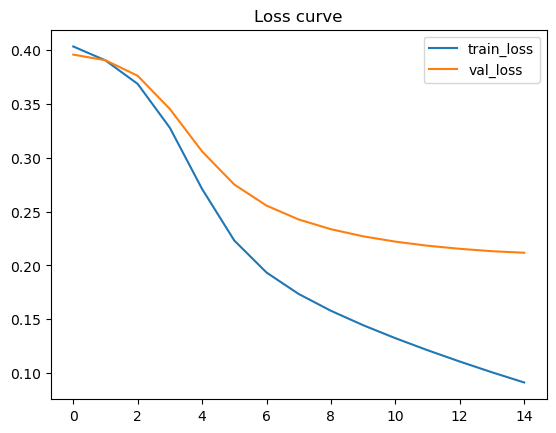

In [12]:
# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()

In [13]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [18:51<00:00, 46.04it/s]


Evaluation result: [NDCG@10: 0.025537, Recall@10: 0.051103]


# Use the Whole Training Data to Train

In [14]:
df_rate = df_ratings

In [15]:
df_rate['Rating'] -= 3
df_rate['Rating'] /= 2

In [16]:
dataset = tf.data.Dataset.from_tensor_slices(df_rate)
dataset = dataset.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)

# build the model
model = FunkSVDRecommender(m_users=M_USERS, n_items=N_ITEMS, embedding_size=EMBEDDING_SIZE, learning_rate=LEARNING_RATE)
train_losses = []
for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    train_losses.append(avg_train_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}\n')

Epoch 1:


Training:   0%|          | 0/1836 [00:00<?, ?it/s]

Tensor("Identity:0", shape=(512, 512), dtype=float32)


Training: 100%|█████████▉| 1830/1836 [00:37<00:00, 47.65it/s]

Tensor("Identity:0", shape=(242, 512), dtype=float32)


Training: 100%|██████████| 1836/1836 [00:37<00:00, 48.64it/s]


Epoch 1 train_loss: 0.4020

Epoch 2:


Training: 100%|██████████| 1836/1836 [00:38<00:00, 47.89it/s]


Epoch 2 train_loss: 0.3887

Epoch 3:


Training: 100%|██████████| 1836/1836 [00:35<00:00, 51.59it/s]


Epoch 3 train_loss: 0.3657

Epoch 4:


Training: 100%|██████████| 1836/1836 [00:36<00:00, 49.70it/s]


Epoch 4 train_loss: 0.3226

Epoch 5:


Training: 100%|██████████| 1836/1836 [00:38<00:00, 47.77it/s]


Epoch 5 train_loss: 0.2650

Epoch 6:


Training: 100%|██████████| 1836/1836 [00:37<00:00, 48.41it/s]


Epoch 6 train_loss: 0.2193

Epoch 7:


Training: 100%|██████████| 1836/1836 [00:37<00:00, 49.26it/s]


Epoch 7 train_loss: 0.1914

Epoch 8:


Training: 100%|██████████| 1836/1836 [00:36<00:00, 50.83it/s]


Epoch 8 train_loss: 0.1722

Epoch 9:


Training: 100%|██████████| 1836/1836 [00:38<00:00, 48.11it/s]


Epoch 9 train_loss: 0.1570

Epoch 10:


Training: 100%|██████████| 1836/1836 [00:37<00:00, 49.17it/s]


Epoch 10 train_loss: 0.1437

Epoch 11:


Training: 100%|██████████| 1836/1836 [00:37<00:00, 48.61it/s]


Epoch 11 train_loss: 0.1317

Epoch 12:


Training: 100%|██████████| 1836/1836 [00:37<00:00, 49.11it/s]


Epoch 12 train_loss: 0.1205

Epoch 13:


Training: 100%|██████████| 1836/1836 [00:35<00:00, 51.72it/s]


Epoch 13 train_loss: 0.1099

Epoch 14:


Training: 100%|██████████| 1836/1836 [00:35<00:00, 51.12it/s]


Epoch 14 train_loss: 0.0999

Epoch 15:


Training: 100%|██████████| 1836/1836 [00:38<00:00, 47.77it/s]

Epoch 15 train_loss: 0.0904



In [17]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')

Evaluating: 100%|██████████| 52089/52089 [20:17<00:00, 42.78it/s]


Evaluation result: [NDCG@10: 0.061196, Recall@10: 0.121691]


In [18]:
model.save('funksvd_model_HANK')

Tensor("Identity:0", shape=(None, 512), dtype=float32)
Tensor("Identity:0", shape=(None, 512), dtype=float32)
Tensor("Identity:0", shape=(512, 512), dtype=float32)
Tensor("Identity:0", shape=(242, 512), dtype=float32)
Tensor("Identity:0", shape=(None, 512), dtype=float32)


Tensor("Identity:0", shape=(None, 512), dtype=float32)
INFO:tensorflow:Assets written to: funksvd_model_HANK/assets


INFO:tensorflow:Assets written to: funksvd_model_HANK/assets
